# SARIMA Report
**PSTAT 174 Time Series Final Project**

*Coby Wilcox, 4812764*

In this report I'll go step by step how I create my SARIMA model. I'll try to lay out all of my thought processes and explanations for what everything means throughout the report.

In [3]:
# ! pip install musdb
# ! pip install stempeg
# # Probably will need to install ffmpeg for these modules to work. It can be installed pretty easily at https://ffmpeg.org/download.html 

import musdb
import numpy as np
import matplotlib.pyplot as plt
import statsmodels as sm
import IPython.display as ipd
import librosa
import display

### Data

**MUSDB-18 Dataset** : a dataset of 150 full lengths music tracks (~10h duration) of different genres along with their isolated drums, bass, vocals and others stems. For this assignment I'll be using their sample dataset though, which has tracks of only 6 sec durations. The song I will be working with is called *Clara Berry And Wooldog - Waltz For My Victims*

In [5]:
mus = musdb.DB(download=True)
_, audio, sr = display.load_track(mus)

Step 1) Plot data

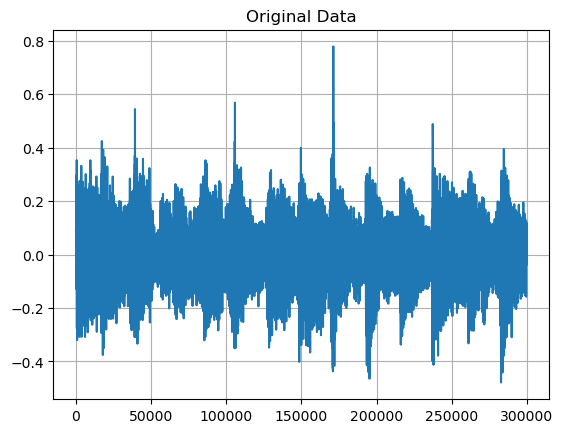

In [7]:
plt.plot(audio)
plt.title("Original Data")
plt.grid()

First I should take a look at my data, just to famaliarize myself with how it looks and what to expect. Upon examining it there are number of things to note:  
- the data has a lot of observations, > 300,000, to address this I should subset the data.
- the data is entirely sinal, this is to be expected as all audio data will be, but we should keep this in mind for the model.

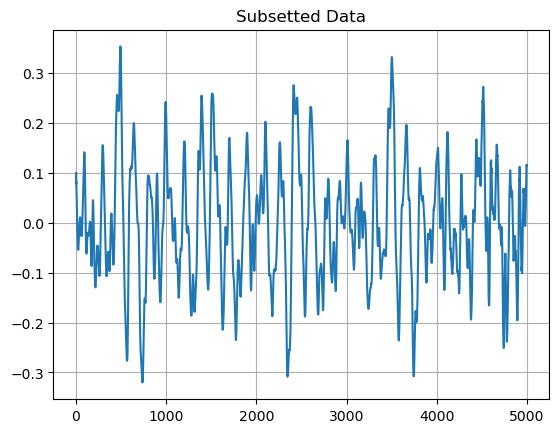

In [10]:
x, y = audio[:5000], audio[5000:5500] # Because the data is hundreds of thousands of samples long, I am going to limit it to only 5000 samples to avoid super long function run times.
plt.plot(x)
plt.title("Subsetted Data")
plt.grid()

Step 2 and 3) Transform and Applying differencing


The data appears to have a constant mean and variance, however to check, I will use an AD-Fuller test.

In [11]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(x)
result[1]

1.640743060431915e-20

With a AD Fuller test value of much below .05, we are free to assume the data is stationary. However to make sure it is a good idea to plot the ACF and PACF of the data.

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
def plot_acf_pacf(data, nlags=50):
    fig, axes = plt.subplots(1,2,figsize=(8,4))

    plot_acf(data, ax=axes[0], lags=nlags)
    axes[0].set_title('ACF Plot')
    plot_pacf(data, ax=axes[1], lags=nlags)
    axes[1].set_title('PACF Plot')

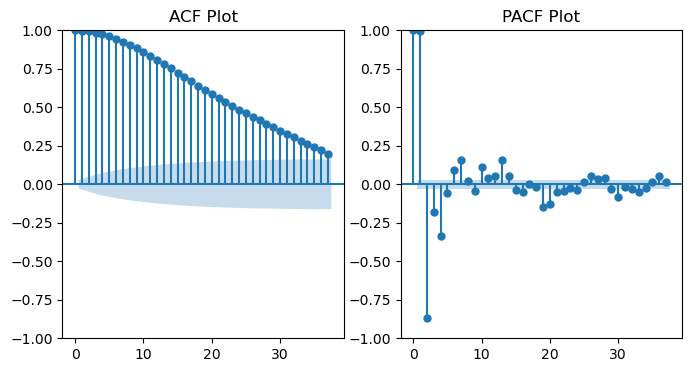

In [12]:
plot_acf_pacf(x)

Looking at the two plots we may need to apply a bit of differencing. The PACF plot looks quite good, however the ACF plot is slowly decreasing with increase in lag. A clear sign of the data values being correlated with their previous values. While the values being correlated with previous values isn't really a bad sign when you are dealing with audio data, it is good practice to difference data that apppears in this way. So after applying a couple of differencing functions the ACF functions appear to be better.

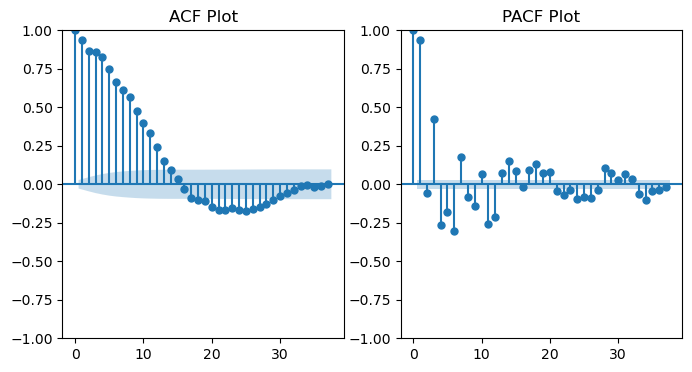

In [13]:
x1 = np.diff(x)
plot_acf_pacf(x1)

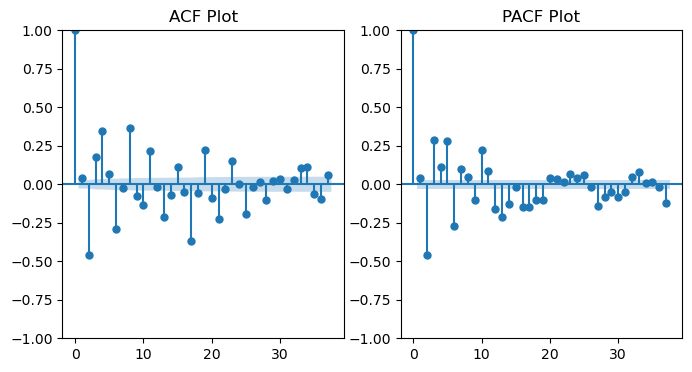

In [14]:
x2 = np.diff(x1)
plot_acf_pacf(x2)

The ACF chart looks much more reasonable now, but ACF and PACF does seem to suggest some seasonality, which makes sense as the audio data is sinal. 

Step 4) Parameter identification

Looking at these ACF and PACF charts, the dip below the area of significance at $h=13$ for ACF and $h=7$. While they do come back above signifcance many times throughout the charts , setting $p$ or $q$ parameters above 10 can cause some heavy computation times, so I'll stick to $p=9$ and $q=7$ just to keep the params low to begin with.

Also it looks like towards the end the ACF is going to begin rising again, so to check for seasonality I increased the number of lags shown.

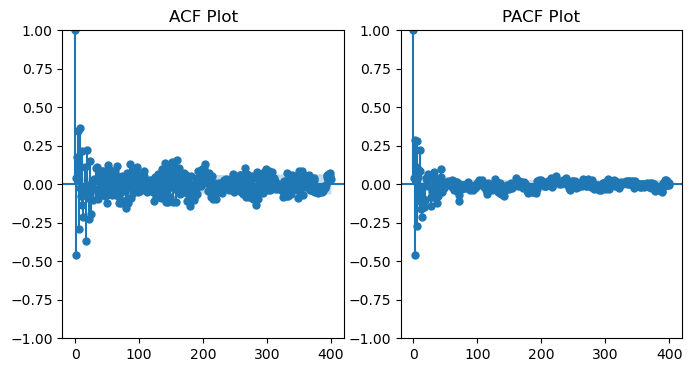

In [18]:
plot_acf_pacf(x2,nlags=400)

Looking at the ACF plots with more lags, we can see there is a seasonal rise around the 50 lag mark, which we can likely assume to be our seasonality value. However, we first should check this by examining our dominant frequencies with a periodogram.

172.265625


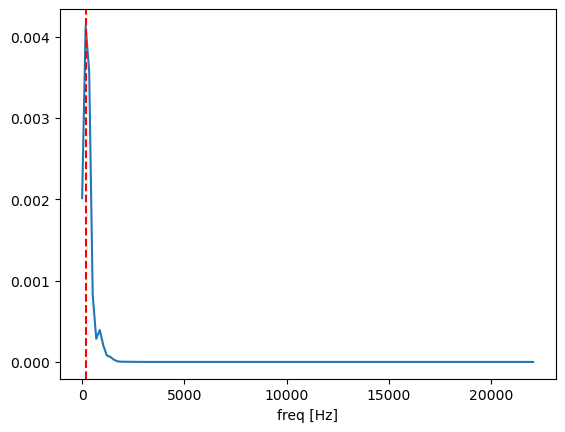

In [23]:
Nfft = 256
stft = librosa.stft(x, n_fft=Nfft)
freqs = librosa.fft_frequencies(sr=sr, n_fft=Nfft)
power = np.abs(stft)**2

plt.plot(freqs, np.mean(power, axis=1)/(Nfft/2)**2)
plt.xlabel('freq [Hz]')
dominant_freq = freqs[np.argmax(np.mean(power, axis=1)/(Nfft/2)**2)]
plt.axvline(x=dominant_freq, color='r', linestyle='--', label='Vertical Line at x=3')
print(dominant_freq)

It's good that we checked as the dominant frequency appears to be ~172 actually. With this information I would like to set our $s$ parameter to be $\frac{\text{length of our data}}{\text{dominant frequency}}$ as we did in class. Doing this we get a value of about ~30.

In [25]:
s_estimate = len(x) / dominant_freq
print(s_estimate)

29.024943310657598


However the problem is that setting a $s$ parameter high in a SARIMA model results in frankly absurd computation times, and knowing the likely lack of good fit this model we be for our data, isn't really quite worth the wait. To try to take this information into account I set the $s$ parameter to be the least common divisor 30 being 3.

Step 5) Diagnostics

In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

order = (9, 2, 7, 3)
model = SARIMAX(x, seasonal_order=order)

model_fit = model.fit()
model_fit.summary()

c:\Users\cobyw\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\cobyw\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                               SARIMAX Results                                               
=============================================================================================================
Dep. Variable:                                                     y   No. Observations:                 5000
Model:             SARIMAX(1, 0, 0)x(9, 2, [1, 2, 3, 4, 5, 6, 7], 3)   Log Likelihood               21075.602
Date:                                               Thu, 13 Jun 2024   AIC                         -42115.204
Time:                                                       16:57:29   BIC                         -41997.916
Sample:                                                            0   HQIC                        -42074.094
                                                              - 5000                                         
Covariance Type:                                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8729      0.007    117.084      0.000       0.858       0.888
ar.S.L3       -0.1583      0.086     -1.839      0.066      -0.327       0.010
ar.S.L6       -0.1229      0.075     -1.635      0.102      -0.270       0.024
ar.S.L9        0.3041      0.073      4.163      0.000       0.161       0.447
ar.S.L12      -0.1826      0.056     -3.258      0.001      -0.293      -0.073
ar.S.L15      -0.4457      0.062     -7.212      0.000      -0.567      -0.325
ar.S.L18      -0.4185      0.073     -5.711      0.000      -0.562      -0.275
ar.S.L21      -0.1725      0.047     -3.699      0.000      -0.264      -0.081
ar.S.L24       0.0678      0.045      1.518      0.129      -0.020       0.155
ar.S.L27      -0.1117      0.045     -2.493      0.013      -0.200      -0.024
ma.S.L3       -0.2799      0.088     -3.190      0.001      -0.452      -0.108
ma.S.L6       -0.2365      0.084     -2.814      0.005      -0.401      -0.072
ma.S.L9       -0.1310      0.091     -1.446      0.148      -0.309       0.047
ma.S.L12       0.1303      0.055      2.381      0.017       0.023       0.238
ma.S.L15       0.2773      0.052      5.307      0.000       0.175       0.380
ma.S.L18      -0.1482      0.057     -2.590      0.010      -0.260      -0.036
ma.S.L21      -0.1668      0.045     -3.731      0.000      -0.254      -0.079
sigma2       1.26e-05   2.32e-07     54.411      0.000    1.21e-05    1.31e-05
===================================================================================
Ljung-Box (L1) (Q):                1455.95   Jarque-Bera (JB):              1856.89
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.12   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Okay the AIC scores are not super promising, so to check I will fit a couple of other models to see if different parameters work better. 

In [30]:
order = (1, 1, 1, 3)
model1 = SARIMAX(x, seasonal_order=order)

model_fit1 = model.fit()
model_fit1.summary()

c:\Users\cobyw\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\cobyw\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                               SARIMAX Results                                               
=============================================================================================================
Dep. Variable:                                                     y   No. Observations:                 5000
Model:             SARIMAX(1, 0, 0)x(9, 2, [1, 2, 3, 4, 5, 6, 7], 3)   Log Likelihood               21075.602
Date:                                               Thu, 13 Jun 2024   AIC                         -42115.204
Time:                                                       16:58:45   BIC                         -41997.916
Sample:                                                            0   HQIC                        -42074.094
                                                              - 5000                                         
Covariance Type:                                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8729      0.007    117.084      0.000       0.858       0.888
ar.S.L3       -0.1583      0.086     -1.839      0.066      -0.327       0.010
ar.S.L6       -0.1229      0.075     -1.635      0.102      -0.270       0.024
ar.S.L9        0.3041      0.073      4.163      0.000       0.161       0.447
ar.S.L12      -0.1826      0.056     -3.258      0.001      -0.293      -0.073
ar.S.L15      -0.4457      0.062     -7.212      0.000      -0.567      -0.325
ar.S.L18      -0.4185      0.073     -5.711      0.000      -0.562      -0.275
ar.S.L21      -0.1725      0.047     -3.699      0.000      -0.264      -0.081
ar.S.L24       0.0678      0.045      1.518      0.129      -0.020       0.155
ar.S.L27      -0.1117      0.045     -2.493      0.013      -0.200      -0.024
ma.S.L3       -0.2799      0.088     -3.190      0.001      -0.452      -0.108
ma.S.L6       -0.2365      0.084     -2.814      0.005      -0.401      -0.072
ma.S.L9       -0.1310      0.091     -1.446      0.148      -0.309       0.047
ma.S.L12       0.1303      0.055      2.381      0.017       0.023       0.238
ma.S.L15       0.2773      0.052      5.307      0.000       0.175       0.380
ma.S.L18      -0.1482      0.057     -2.590      0.010      -0.260      -0.036
ma.S.L21      -0.1668      0.045     -3.731      0.000      -0.254      -0.079
sigma2       1.26e-05   2.32e-07     54.411      0.000    1.21e-05    1.31e-05
===================================================================================
Ljung-Box (L1) (Q):                1455.95   Jarque-Bera (JB):              1856.89
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.12   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

It seems like our scores are not getting much better, so in the end I have decided that my orginal estimation should suffice. Now to check the diganostics of my model.

                                               SARIMAX Results                                               
Dep. Variable:                                                     y   No. Observations:                 5000
Model:             SARIMAX(1, 0, 0)x(9, 2, [1, 2, 3, 4, 5, 6, 7], 3)   Log Likelihood               21075.602
Date:                                               Thu, 13 Jun 2024   AIC                         -42115.204
Time:                                                       17:01:44   BIC                         -41997.916
Sample:                                                            0   HQIC                        -42074.094
                                                              - 5000                                         
Covariance Type:                                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

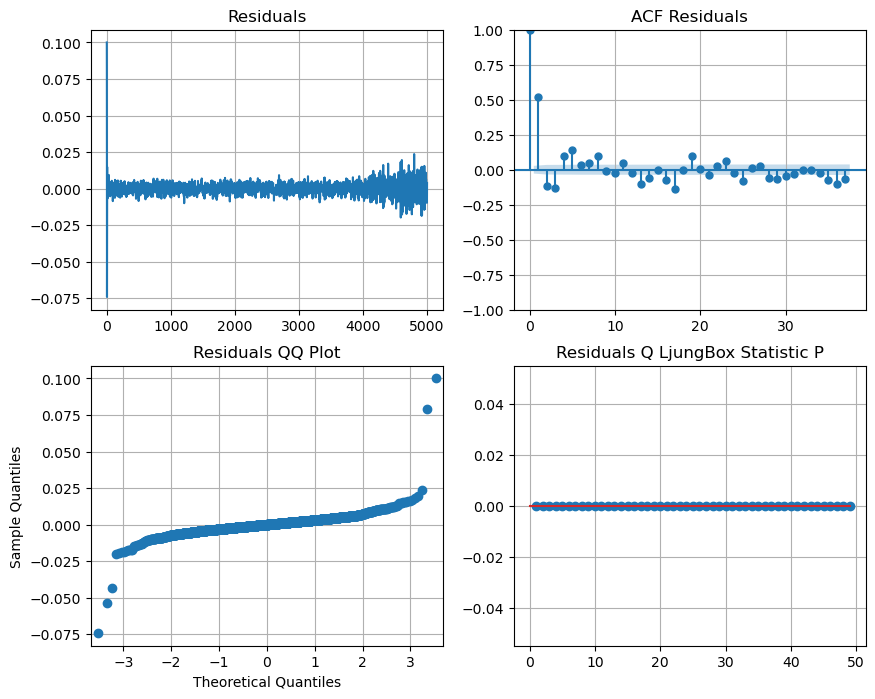

In [31]:
display.diagnostics(model_fit)

The model appears to be doing okay. 
- The model's residuals seem to look mostly like noise
- The QQ plot appears to look normal.
- The ACF of the residuals also appears to look mostly like noise
- The QQ Ljung Statistic is very high, so our model is definitely not a very good fit.

And lastly to display my prediction for the next 500 samples in the audio lets see how it looks.

Step 6) Forecasting

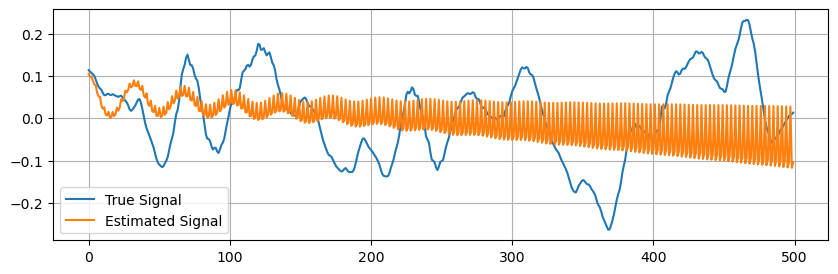

In [32]:
display.forecast(model_fit, y)

The results of the SARIMA model were not very impressive. Generally what I learned from this process was that SARIMA models are not very apt at working with music files overall.